#### To test: 
1. Create a folder ~/data/luna16/
2. Create a folder ~/data/luna16/hdf5
    -Under this copy UNET_weights_H5.h5 (download from google drive)
3. Create a folder ~/data/luna16/hdf5/HO5 
    -Under this copy 64x64x64-patch-withdiam_sample.hdf5

In [1]:
import numpy as np
import h5py
import pandas as pd
import keras

from ipywidgets import interact

#from UNET_utils import *
from UNET_model_def import *
from matplotlib import pyplot as plt
%matplotlib inline

/home/tony/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
HOLDOUT = 5
TOP_DIR = "/home/tony"
HO_dir = 'hdf5/HO{}/'.format(HOLDOUT)
data_dir = '{}/data/luna16/'.format(TOP_DIR)
#model_wghts = 'hdf5/UNET_weights_modelB_H{}.h5'.format(HOLDOUT)


# model_wghts = '{}hdf5/UNET_weights_modelC_exp1_lr02_H{}.h5'.format(data_dir,HOLDOUT)
# model = unet3D_sizeagnostic_Model16()
# hu_norm_on = True


# model_wghts = '{}hdf5/UNET_weights_modelB_exp1_lr009_H{}.h5'.format(data_dir,HOLDOUT)
model_wghts = "{}hdf5/UNET_weights_modelB_exp1_lr009_BSexp1_H{}.h5".format(data_dir, HOLDOUT)
model = unet3D_Model6_Model13((None,None,None,1))
hu_norm_on = False




3D U-Net Segmentation


In [3]:
model.load_weights(model_wghts)

In [4]:
hdf = h5py.File("{}{}/64x64x64-patch-withdiam_HO{}sample.hdf5".format(data_dir, HO_dir, HOLDOUT), "r")

In [5]:
list(hdf.keys())

['centroid', 'diameter_label', 'input', 'notrain', 'output', 'subsets', 'uuid']

In [6]:
class1 = np.where(hdf["output"][:,0]==1)[0]  # Where are class 1
class0 = np.where(hdf["output"][:,0]==0)[0]  # Where are class 1

In [7]:
len(class1)

19

In [8]:
def hu_norm(npzarray):
    
    """
    Normalize pixel depth into Hounsfield units (HU), between -1000 - 400 HU
    All other HU will be masked. Then we normalize pixel values between 0 and 1.
    """
    if hu_norm_on:
        maxHU, minHU = 400., -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
    return npzarray

In [79]:
print("Class 1")

class1idx = 0   #5,8 ;   11 shows 2 class 1; 12, 13

# Choose one of the class 1 ROIs

img1 = hdf["input"][class1[class1idx],:].reshape(64,64,64,1)  


predict_array = model.predict(hu_norm(np.expand_dims(img1,0)), verbose=2)

prediction_mask1 = np.round(predict_array)


def displaySlice(sliceNo):
    
    
    plt.figure(figsize=(15,15))
    plt.subplot(2,3,1)
    plt.imshow(img1[:,:,sliceNo,0], cmap="bone")
    plt.title("Image")

    plt.subplot(2,3,2)
    plt.imshow(prediction_mask1[0,:,:,sliceNo,0], cmap="bone")
    plt.title("Tumor Prediction")

    plt.subplot(2,3,3)
    plt.imshow(img1[:,:,sliceNo,0], cmap="bone")
    plt.imshow(prediction_mask1[0,:,:,sliceNo,0], alpha=0.5, cmap="Reds")
    plt.title("Overlay")
    
    plt.subplot(2,3,4)
    plt.imshow(img1[sliceNo,:,:,0], cmap="bone")
    plt.title("Image")

    plt.subplot(2,3,5)
    plt.imshow(prediction_mask1[0,sliceNo,:,:,0], cmap="bone")
    plt.title("Tumor Prediction")

    plt.subplot(2,3,6)
    plt.imshow(img1[sliceNo,:,:,0], cmap="bone")
    plt.imshow(prediction_mask1[0,sliceNo,:,:,0], alpha=0.5, cmap="Reds")
    plt.title("Overlay")
    
    
    #plt.savefig("saved_imgs/class1/class1_slice{}".format(sliceNo), dpi=600, bbox_inches="tight")
    
    
interact(displaySlice, sliceNo=(1,img1.shape[2],1)); 


print(hdf["uuid"][0])

Class 1


A Jupyter Widget

[b'1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800']


In [80]:
print("Class 1")

class1idx = 0   #5,8 ;   11 shows 2 class 1; 12, 13, 14, 18

# Choose one of the class 1 ROIs

img1 = hdf["input"][class1[class1idx],:].reshape(64,64,64,1)  


predict_array = model.predict(hu_norm(np.expand_dims(img1,0)), verbose=2)

prediction_mask1 = np.round(predict_array)


Class 1


In [81]:
import blob

In [82]:
b1 = blob.findBlobs(prediction_mask1[0,:,:,:,0].reshape(64,64,64), 
                    scales=range(2, 30), threshold=0.1)

/home/tony/Documents/Capstone/ucsd-dse-capstone/Models/blob.py:46: RuntimeWarning: divide by zero encountered in true_divide
  / (12 * d)) * valid


In [83]:
b1

array([[ 2, 14, 26, 29],
       [ 2, 25, 15, 30],
       [ 2, 33, 24, 35],
       [ 3, 32, 19, 27]])

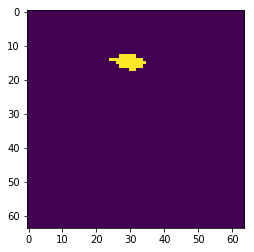

In [77]:
plt.imshow(prediction_mask1[0,26,:,:,0])

In [124]:
for sliceNo in range(max(img1.shape)):
    
    
    plt.figure(figsize=(15,15))
    
    
    plt.subplot(2,3,1)
    plt.imshow(img1[:,:,sliceNo,0], cmap="bone")
    plt.title("Original Image", fontsize=18)
    plt.text(-37,32,"Transverse\n    plane", fontsize=32, color="blue", fontname="FreeSans")

    plt.subplot(2,3,2)
    plt.imshow(prediction_mask1[0,:,:,sliceNo,0], cmap="bone")
    plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")

    plt.subplot(2,3,3)
    plt.imshow(img1[:,:,sliceNo,0], cmap="bone")
    plt.imshow(prediction_mask1[0,:,:,sliceNo,0], alpha=0.5, cmap="Reds")
    #plt.colorbar()
    plt.title("Overlay", fontsize=18, fontname="FreeSans")
    
    plt.subplot(2,3,4)
    plt.imshow(img1[sliceNo,:,:,0], cmap="bone")
    plt.title("Original Image", fontsize=18)
    plt.text(-30,32,"Coronal\n  plane", fontsize=32, color="blue", fontname="FreeSans")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")
    
    plt.subplot(2,3,5)
    plt.imshow(prediction_mask1[0,sliceNo,:,:,0], cmap="bone")
    plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.subplot(2,3,6)
    plt.imshow(img1[sliceNo,:,:,0], cmap="bone", interpolation="none")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")
    
    plt.imshow(prediction_mask1[0,sliceNo,:,:,0], alpha=0.5, cmap="Reds")
    #plt.colorbar()
    plt.title("Overlay", fontsize=18, fontname="FreeSans")
    
    plt.tight_layout()
    
    import os
    directory = "saved_imgs/class1/candidate{}/".format(class1idx)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig("{}slice{}".format(directory, sliceNo), dpi=600, bbox_inches="tight")
    
    plt.close()
    

In [13]:
print("Class 0")
class0idx = 347

# Choose one of the class 0 ROIs

img0 = hdf["input"][class0[class0idx],:].reshape(64,64,64,1)  


predict_array = model.predict(hu_norm(np.expand_dims(img0,0)), verbose=2)

prediction_mask0 = np.round(predict_array)

Class 0


In [15]:
for sliceNo in range(max(img0.shape)):
    
    
    plt.figure(figsize=(15,15))
    
    
    plt.subplot(2,3,1)
    plt.imshow(img0[:,:,sliceNo,0], cmap="bone")
    plt.title("Original Image", fontsize=18)
    plt.text(-37,32,"Transverse\n    plane", fontsize=32, color="blue", fontname="FreeSans")

    plt.subplot(2,3,2)
    plt.imshow(prediction_mask0[0,:,:,sliceNo,0], cmap="bone")
    plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")

    plt.subplot(2,3,3)
    plt.imshow(img0[:,:,sliceNo,0], cmap="bone")
    plt.imshow(prediction_mask0[0,:,:,sliceNo,0], alpha=0.5, cmap="Reds")
    #plt.colorbar()
    plt.title("Overlay", fontsize=18, fontname="FreeSans")
    
    plt.subplot(2,3,4)
    plt.imshow(img0[sliceNo,:,:,0], cmap="bone")
    plt.title("Original Image", fontsize=18)
    plt.text(-30,32,"Coronal\n  plane", fontsize=32, color="blue", fontname="FreeSans")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")
    
    plt.subplot(2,3,5)
    plt.imshow(prediction_mask0[0,sliceNo,:,:,0], cmap="bone")
    plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.subplot(2,3,6)
    plt.imshow(img0[sliceNo,:,:,0], cmap="bone", interpolation="none")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")
    
    plt.imshow(prediction_mask0[0,sliceNo,:,:,0], alpha=0.5, cmap="Reds")
    #plt.colorbar()
    plt.title("Overlay", fontsize=18, fontname="FreeSans")
    
    plt.tight_layout()
    
    import os
    directory = "saved_imgs/class0/candidate{}/".format(class0idx)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig("{}slice{}".format(directory, sliceNo), dpi=600, bbox_inches="tight")
    
    plt.close()
    

In [14]:
def displaySlice(sliceNo):
    
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(img0[:,:,sliceNo,0], cmap="bone")
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(prediction_mask0[0,:,:,sliceNo,0], cmap="bone")
    plt.title("Tumor Prediction")

    plt.subplot(1,3,3)
    plt.imshow(img0[:,:,sliceNo,0], cmap="bone")
    plt.imshow(prediction_mask0[0,:,:,sliceNo,0], alpha=0.5, cmap="Reds")
    plt.title("Overlay")
    
    
    
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(img0[sliceNo,:,:,0], cmap="bone")
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(prediction_mask0[0,sliceNo,:,:,0], cmap="bone")
    plt.title("Tumor Prediction")

    plt.subplot(1,3,3)
    plt.imshow(img0[sliceNo,:,:,0], cmap="bone")
    plt.imshow(prediction_mask0[0,sliceNo,:,:,0], alpha=0.5, cmap="Reds")
    plt.title("Overlay")
    
    
    
interact(displaySlice, sliceNo=(1,img0.shape[2],1)); 

print(hdf["uuid"][0])

A Jupyter Widget

[b'1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800']


In [11]:
#hdf.close()

In [12]:
img1.shape

(64, 64, 64, 1)

In [13]:
img0.shape

(64, 64, 64, 1)

In [14]:
prediction_mask0.shape

(1, 64, 64, 64, 1)

In [15]:
prediction_mask1.shape

(1, 64, 64, 64, 1)